# Setup
To setup the environment run the following commands on kaggle

In [1]:
!cp /kaggle/input/a3-2-1/A3_Part2/environment.yml /kaggle/working/
!cp /kaggle/input/a3-2-1/A3_Part2/install.sh /kaggle/working/


!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


Run your .py file on CLI using the following command

```bash
# Running code for training. save the model in the same directory with name "vae.pth"
# Save the GMM parameters in the same folder. You can use pickle to save the parameters. 
!python vae.py path_to_train_dataset path_to_val_dataset train vae.pth gmm_params.pkl



# Running code for vae reconstruction.
# This should save the reconstruced images in numpy format. see below for more details.
!python vae.py path_to_test_dataset_recon test_reconstruction vae.pth

#Running code for class prediction during testing
!python vae.py path_to_test_dataset test_classifier vae.pth gmm_params.pkl
```

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# To be tested

### Data Preparation and Loading
- **Data Loading:**
  - Load images as PyTorch tensors.
  - Implement a custom `Dataset` class for easy data handling.
- **Data Transformation & Preprocessing:**
  - Padding, cropping, and resizing to standardize image dimensions if needed.
  - Apply transforms like grayscale normalization, resizing, and scaling between [0, 1].

### Exploratory Data Analysis (EDA)
- Visualize a few images from each class (1, 4, 8) for reference.
- Calculate the mean and variance of pixel intensities across the dataset.
- Plot pixel intensity histograms and class distributions to check for imbalances.

---

### Model Architectures & Variants
- **Encoder-Decoder Architectures to Try:**
  - **Dense Layers Only**: Simple MLP-based VAE for both encoder and decoder.
  - **CNN-Based Encoder, Dense Decoder**: CNN layers in the encoder to capture spatial patterns, with dense layers for the decoder.
  - **Hybrid Models**: Experiment with CNN-based encoder and decoder for richer representation.
  - **Residual and Skip Connections**: Add residual connections in the encoder to improve information flow.
  
- **Scaling & Regularization Techniques:**
  - Batch Normalization and Layer Normalization
  - Experiment with Dropout, DropBlock
  - Learning rate schedules: `OneCycleLR`, `CyclicLR`, or Learning Rate Warm-Up
  
- **Hyperparameter Tuning:**
  - Adjust KL divergence weight (`β`) to balance reconstruction and regularization.
  - Try different activation functions in hidden layers (`ReLU`, `Leaky ReLU`, etc.)
  - Tune the latent space dimension size (try 2, 3, and 5 dimensions)

---

### Training Strategies
- **Training the VAE:**
  - Focus on reconstruction first, evaluating if the VAE captures essential features.
  - Set up and test different learning rate schedulers for stable training.
  - Monitor loss curves (reconstruction and KL divergence separately) using TensorBoard.

- **Generating Images & Latent Space Evaluation:**
  - Sample from the 2D latent space grid to generate new digits and inspect their quality.
  - Plot the latent space embeddings of the test/validation set for digit clustering.

---

### Gaussian Mixture Model (GMM) on Latent Space
- **GMM Training:**
  - Use validation data to initialize GMM cluster means.
  - Manually implement the GMM training loop to ensure it’s optimized for classification.
  - Plot GMM cluster ellipses over the latent space embeddings.

- **Classification Techniques & Evaluation:**
  - Use Maximum Likelihood estimation to classify new data with the trained GMM.
  - Calculate accuracy, precision, recall, and F1 score on the validation dataset.

---

### Evaluation & Visualization Techniques
- **Reconstruction Evaluation:**
  - Compare reconstruction quality using MSE and SSIM (Structural Similarity Index).
  - Save the reconstructed images for comparison with the original ones.

- **Debugging and Insights:**
  - Use Grad-CAM to understand activations if using CNN layers.
  - Experiment with tools like TensorBoard or Weights & Biases to log training details.
  
- **Calibration Techniques:**
  - Try model calibration techniques to improve class separation if needed.
  - Experiment with temperature scaling to adjust probability estimates.

---

### Advanced Options (Optional)
- **Data Augmentation:**
  - Implement slight augmentations, like brightness/contrast jittering, to create variations in the training set.
  - Explore Albumentations for adaptive augmentation if you need more samples.
  
- **Addressing Imbalances (if applicable):**
  - Use oversampling for minority classes or implement focal loss for better handling of imbalances.



# DataLoader
Loading the npz files from the dataset

In [3]:
train_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_train.npz')
val_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_val_recon.npz')

## Custom Dataset class
Custom dataset class implemented to load the data during training and testing

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.labels = torch.tensor(labels, dtype=torch.long) # Convert to PyTorch tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

Setting up the dataset and dataloader to check the max value with which the images will be scaled, thus scaling the pixels to [0,1] range

In [5]:
# dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'])
# loader = DataLoader(dataset, batch_size=64, shuffle=True)

# idx = 5
# for image, _ in loader:
#     print(image.max())
#     idx += 1
#     if (idx > 5):
#         break

In [6]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
    transforms.Lambda(lambda x: x.unsqueeze(0) if x.ndim == 2 else x),  # Add channel if needed
    transforms.Normalize(
        mean = (0,), 
        std = (255,)
    )
])

In [7]:
train_dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(data = val_set['data'], labels = train_set['labels'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Basic Implementation

### Log
#### 1) Basic Dense NN Implementation
- Reconstruction Loss => Train: 142 Val: 137
- GMM Accuracy => 0.13333333333333333
- GMM Precision 'macro' => 0.13333333333333333
- GMM Recall 'macro' => 0.044444444444444
- GMM F1 score 'macro' => 0.66666666666666667

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.Linear(512, 256),
        )

        self.z_mean = nn.Linear(256, 2)
        self.z_log_var = nn.Linear(256, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.Linear(256, 512),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [9]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [10]:
def train(epoch, batch_size=64):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        data = data.to(device)
        optimizer.zero_grad()

        encoded, mu, log_var, recon_batch = vae(data)
        loss = loss_fn(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [11]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 28*28)
            data = data.to(device)
            
            ecoded, mu, log_var, recon = vae(data)
            
            # sum up batch loss
            test_loss += loss_fn(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr = 1e-5)

train_loss = []
test_loss = []
for epoch in range(1, 51):
    train_loss_epoch = train(epoch)
    test_loss_epoch = test()
    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)

Train Epoch: 1 [0/14748 (0%)]	Loss: 551.558228
Train Epoch: 1 [6400/14748 (43%)]	Loss: 504.092041
Train Epoch: 1 [12800/14748 (87%)]	Loss: 303.635254
====> Epoch: 1 Average loss: 450.4626
====> Test set loss: 259.5643
Train Epoch: 2 [0/14748 (0%)]	Loss: 259.068817
Train Epoch: 2 [6400/14748 (43%)]	Loss: 227.681671
Train Epoch: 2 [12800/14748 (87%)]	Loss: 214.913345
====> Epoch: 2 Average loss: 222.5785
====> Test set loss: 206.9441
Train Epoch: 3 [0/14748 (0%)]	Loss: 206.258743
Train Epoch: 3 [6400/14748 (43%)]	Loss: 199.052811
Train Epoch: 3 [12800/14748 (87%)]	Loss: 190.408203
====> Epoch: 3 Average loss: 198.4242
====> Test set loss: 193.0039
Train Epoch: 4 [0/14748 (0%)]	Loss: 190.652603
Train Epoch: 4 [6400/14748 (43%)]	Loss: 200.316605
Train Epoch: 4 [12800/14748 (87%)]	Loss: 192.053421
====> Epoch: 4 Average loss: 188.8324
====> Test set loss: 183.4923
Train Epoch: 5 [0/14748 (0%)]	Loss: 184.464142
Train Epoch: 5 [6400/14748 (43%)]	Loss: 179.750351
Train Epoch: 5 [12800/14748 (8

## Train and Test loss for reconstructed images

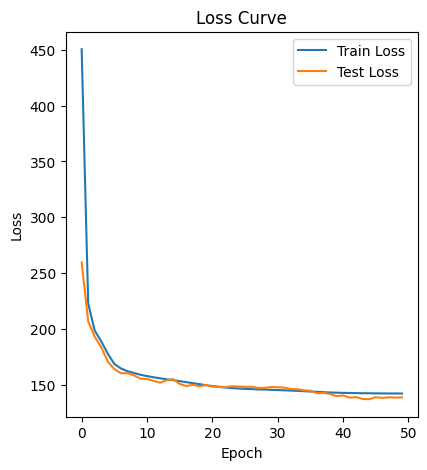

In [13]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Reconstructing image

The reconstruction ability of your implementation will be evaluated. For images in the validation dataset, plot the reconstructed image from VAE and **add in the report**. 

For consistency, use the following code to visualize the reconstructed images.

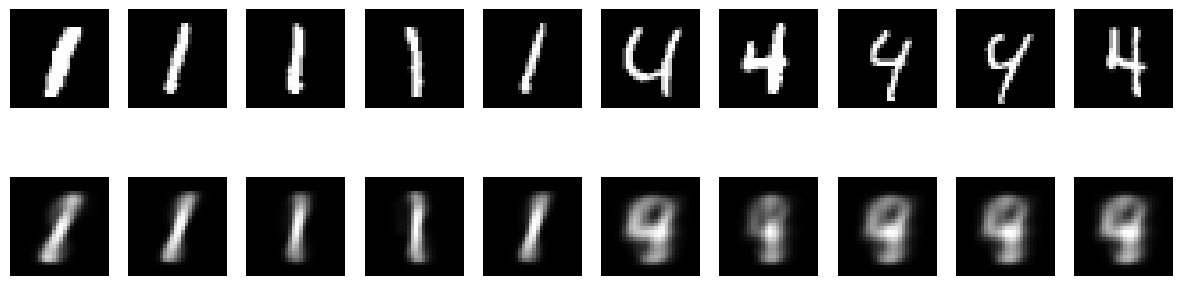

In [14]:
def show_reconstruction(model, val_loader, n=10):
    model.eval()
    data, labels = next(iter(val_loader))

    # Needs to be changed
    my_data = data.view(-1, 28*28)
    my_data = my_data.to(device)
    
    data = data.to(device)
    _, _, _, recon_data = model(my_data) # Needs to be changed
    
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    for i in range(n):
        # Original images
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(recon_data[i].cpu().view(28, 28).detach().numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

n = 10
val_loader = DataLoader(test_dataset, batch_size = n)
show_reconstruction(vae, val_loader, n=n)

## Generating New Images

Note that the latent space of the VAE is normal distribution that allows us to sample latent vectors and pass it to the decoder to generate new images from the data distribution. In this part of the assignment, we will evaluate the VAE's generation capability by uniformly sampling from the latent space. Specifically, use the following code snippet to sample latent vectors, feed them into the VAE’s decoder, and generate new images. **Include these generated images in your report** to show your VAE's generative performance.

You can use the following code to generated images and plot in form of grid..

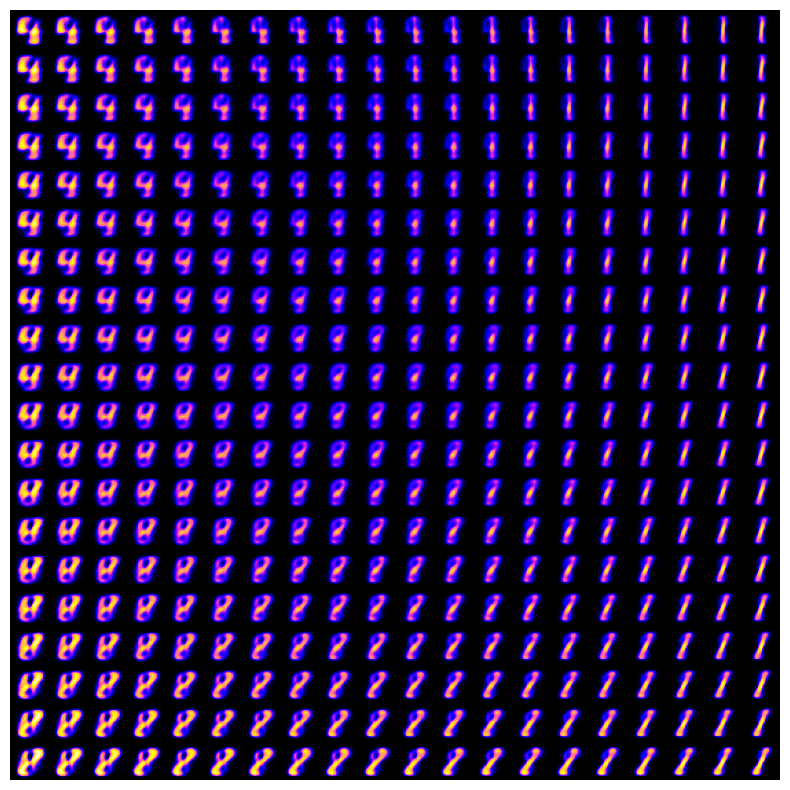

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device='cuda'):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Generate a grid of values between 0.05 and 0.95 percentiles of a normal distribution
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    vae.eval()  # Set VAE to evaluation mode
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = torch.tensor([[xi, yi]], device=device).float()

                # Pass z to VAE Decoder
                digit = vae.decoder(z_sample)
                # Write your code here
                digit = digit.view(digit_size, digit_size).cpu().numpy()

                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit


    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.axis('off')
    plt.show()

plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device='cuda')

## Visualizing Latent Space

To visualize the structure of the VAE's latent space, extract the latent vector for each image in the training dataset, then plot these vectors in a 2D scatter plot. Add this scatter plot to your report and observe the distribution. Look for distinct clustering patterns—ideally, you should see three clusters, each resembling a 2D normal distribution. Comment on whether the clusters are well-separated and follow the expected distribution, indicating the VAE has effectively organized the latent space for classification.

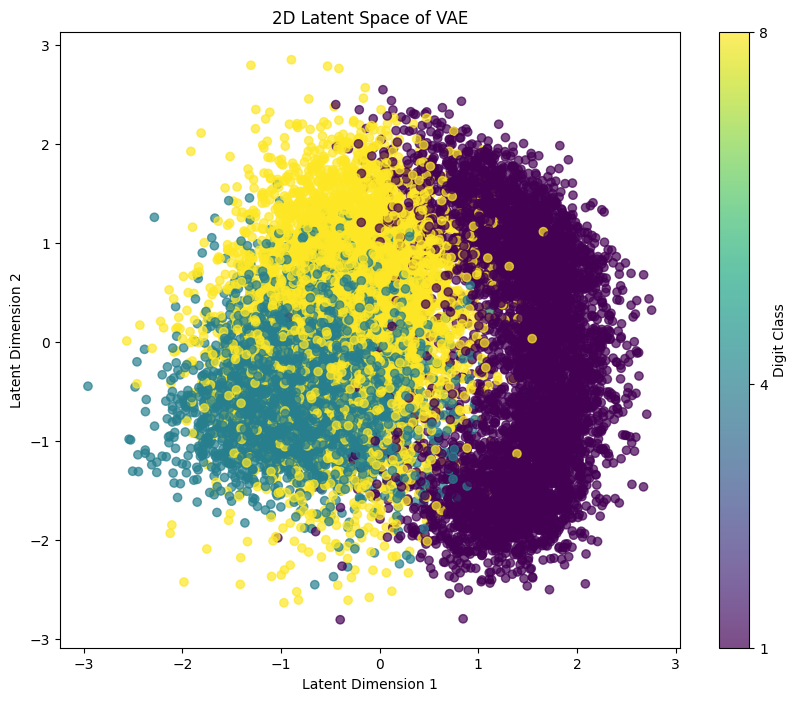

In [16]:
def visualize_latent_space(vae, dataloader, device='cuda'):
    vae.eval()  # Set VAE to evaluation mode
    
    all_latents = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            data = data.view(-1, 28*28)
            labels = labels.to(device)
            
            # Encode data to obtain latent mean (mu) and log variance (log_var)
            encoding = vae.encoder(data)
            mu = vae.z_mean(encoding)
            log_var = vae.z_log_var(encoding)
            
            # Sample latent vector z from the distribution (using reparameterization trick)
            z = vae.reparameterize(mu, log_var)
            
            # Append to lists
            all_latents.append(z.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all collected latent vectors and labels
    all_latents = torch.cat(all_latents).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Plot the 2D latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    
    colorbar = plt.colorbar(scatter, ticks=[1, 4, 8])
    colorbar.set_label('Digit Class')
    colorbar.set_ticklabels(['1','4','8'])
    
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("2D Latent Space of VAE")
    plt.show()

# Example usage with DataLoader, assuming you have a DataLoader named 'train_loader'
visualize_latent_space(vae, train_loader, device='cuda')

# Implementing the GMM

In [89]:
class GMM:
    """
    A Gaussian Mixture Model (GMM) implementation for clustering data, 
    using Expectation-Maximization (EM).
    """
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        """
        Initialize the model parameters.
        Paramters:
            n_components (int): The number of clusters (Gaussian components).
            max_iter (int, optional): Maximum number of iterations for EM algorithm. Defaults to 100.
            tol (float, optional): Convergence threshold for log-likelihood improvement. Defaults to 1e-3.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None # Mixing coefficients (weights of each Gaussian)

    def _initialize_parameters(self, X):
        """
        Initialize means, covariances, and mizing weights.
        Parameters:
            X (ndarray): Input data with shape (n_samples, n_features).
        """
        n_samples, n_features = X.shape
        np.random.seed(0)

        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]

        self.weights = np.full(self.n_components, 1 / self.n_components)

    def _compute_multivariate_gaussian(self, X, mean, covariance):
        """
        Compute multivariate Gaussian probability for each sample in X.
        Parameters:
            X (ndarray): Data points, shape (n_samples, n_features).
            mean (ndarray): Mean vector of a Gaussian component, shape (n_features,).
            covariance (ndarray): Covariance matrix of a Gaussian component, shape (n_features, n_features).

        Returns:
            ndarray: Gaussian probabilities, shape (n_samples,).
        """
        n = X.shape[1]
        cov_inv = np.linalg.inv(covariance)  # Inverse of the covariance matrix
        det_cov = np.linalg.det(covariance)  # Determinant of the covariance matrix

        diff = X - mean  # shape: (n_samples, n_features)

        # Compute the exponent part: diff.T @ cov_inv @ diff (for each sample)
        exponent = np.sum(diff @ cov_inv * diff, axis=1)  # shape: (n_samples,)

        # Calculate the denominator term (same for all samples)
        denominator = (2 * np.pi) ** (n / 2) * np.sqrt(det_cov)  # scalar

        # Compute the Gaussian PDF for each sample
        multivariate_gaussian = (1 / denominator) * np.exp(-0.5 * exponent)

        return multivariate_gaussian

    def _expectation_step(self, X):
        """
        E-step: Calculate responsibility matrix.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).

        Returns:
            ndarray: Responsibility matrix, shape (n_samples, n_components).
        """
        n_samples, _ = X.shape
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            MVG = self._compute_multivariate_gaussian(X, self.means[k], self.covariances[k])
            responsibilities[:, k] = self.weights[k] * MVG

        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum

        return responsibilities

    def _maximization_step(self, X, responsibilities):
        """
        M-step: Update model parameters based on responsibilities.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).
            responsibilities (ndarray): Responsibility matrix.
        """
        n_samples, n_features = X.shape

        for k in range(self.n_components):
            N_k = responsibilities[:, k].sum()

            # Update means
            self.means[k] = (1 / N_k) * np.sum(responsibilities[:, k, None] * X, axis=0)

            # Update covariances
            diff = X - self.means[k]
            self.covariances[k] = (1 / N_k) * np.dot((responsibilities[:, k] * diff.T), diff)

            # Update weights
            self.weights[k] = N_k / n_samples

    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data given the current model parameters.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).

        Returns:
            float: Log-likelihood of the data
        """
        log_likelihood = 0
        for k in range(self.n_components):
            MVG = self._compute_multivariate_gaussian(X, self.means[k], self.covariances[k])
            log_likelihood += self.weights[k] * MVG

        return np.sum(np.log(log_likelihood))

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm
        Parameters:
            X (ndarray): Training data, shape (n_samples, n_features).
        """
        self._initialize_parameters(X)

        log_likelihood_prev = None
        for i in range(self.max_iter):
            responsibilities = self._expectation_step(X)
            self._maximization_step(X, responsibilities)

            log_likelihood = self._compute_log_likelihood(X)
            if log_likelihood_prev is not None and abs(log_likelihood - log_likelihood_prev) < self.tol:
                print(f'Converged in {i} iterations.')
                break
            log_likelihood_prev = log_likelihood

    def predict(self, X):
        """
        Assign each sample to the Gaussian component with the highest responsibility.
        Parameters:
            X (ndarray): Data to predict, shape (n_samples, n_features).

        Returns:
            list: Component labels for each sample.
        """
        responsibilities = self._expectation_step(X)
        return responsibilities.argmax(axis=1)

    def predict_proba(self, X):
        """
        Calculate the probability of each sample for each component.
        Parameters:
            X (ndarray): Data to predict, shape (n_samples, n_features).

        Returns:
            ndarray: Probability matrix, shape (n_samples, n_components).
        """
        return self._expectation_step(X)

In [94]:
# Step 1: Calculate Class-Specific Means for Initial GMM Centers
def compute_class_means(vae, val_loader, device='cpu'):
    """
    Compute the mean of latent vectors for each digit class in the validation dataset.
    
    :param vae: Trained VAE model.
    :param val_loader: DataLoader - Validation data loader with image and labels.
    :param device: str - Device ('cpu' or 'cuda').
    :return: dict - Mapping of class labels to mean latent vectors.
    """
    vae.eval()
    class_latent_vectors = {}
    class_counts = {}

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28)
            images = images.to(device)
            
            encoding = vae.encoder(images)
            means = vae.z_mean(encoding)
            means = means.cpu().numpy()
            labels = labels.cpu().numpy()

            for mean, label in zip(means, labels):
                if label not in class_latent_vectors:
                    class_latent_vectors[label] = []
                    class_counts[label] = 0
                class_latent_vectors[label].append(mean)
                class_counts[label] += 1

    class_means = {label: np.mean(latent_vectors, axis=0) for label, latent_vectors in class_latent_vectors.items()}
    
    return class_means

# Step 2: Train the GMM with Initialized Means from Validation Set
def train_gmm_with_initial_means(gmm, vae, train_loader, init_means, device='cpu'):
    """
    Train the GMM on the latent space representations of the training data.
    
    :param gmm: GMM instance.
    :param vae: Trained VAE model.
    :param train_loader: DataLoader - Training data loader with images.
    :param init_means: dict - Initial cluster centers based on validation set class means.
    :param device: str - Device ('cpu' or 'cuda')
    """
    vae.eval()
    
    # Set initial means in GMM
    gmm.means = np.array([init_means[label] for label in sorted(init_means.keys())])
    
    # Extract latent vectors for training data
    latent_vectors = []
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.view(-1, 28*28)
            images = images.to(device)
            encoding = vae.encoder(images)
            mean = vae.z_mean(encoding)
            latent_vectors.append(mean.cpu().numpy())

    # Concatenate all latent vectors from mini-batches
    latent_vectors = np.vstack(latent_vectors)
    
    # Fit GMM to latent vectors
    gmm.fit(latent_vectors)

# Step 3: Classify New Images with the Trained GMM
def classify_with_gmm(vae, gmm, test_loader, device='cpu'):
    """
    Classify new images by encoding them with the VAE and using the GMM for clustering.
    
    :param vae: Trained VAE model.
    :param gmm: Trained GMM model.
    :param test_loader: DataLoader - Test data loader with images.
    :param device: str - Device ('cpu' or 'cuda')
    :return: list - Predicted class labels for each batch.
    """
    vae.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, 28*28)
            images = images.to(device)
            
            encoding = vae.encoder(images)
            mean = vae.z_mean(encoding)
            mean = mean.cpu().numpy()

            batch_predictions = gmm.predict(mean)
            predictions.extend(batch_predictions)
    
    return predictions

In [95]:
# Compute initial means for GMM using validation dataset
initial_means = compute_class_means(vae, test_loader, device)

# Train GMM with the initial class means
gmm = GMM(n_components=3)
train_gmm_with_initial_means(gmm, vae, train_loader, initial_means, device)

# Classify new test images
predictions = classify_with_gmm(vae, gmm, test_loader, device)

## Visualizing GMM

To visualise the GMM model, plot each Gaussian distribution as an ellipse, with the center representing the mean and the shape reflecting the covariance. This visualisation will help assess whether the learned GMM effectively separates the clusters. Analyze the plot to determine if the clusters are distinct or if there is overlap that could indicate misclassification.

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch

def plot_gmm_ellipses(gmm, X, labels=None):
    """
    Plot the GMM clusters as ellipses, with the mean and covariance
    of each Gaussian component visualized.
    
    :param gmm: GMM instance - Fitted GMM model with means, covariances, and weights.
    :param X: ndarray - Data points in the latent space (n_samples, 2).
    :param labels: list or array, optional - Cluster labels for each sample, if available.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot data points
    if labels is not None:
        for label in np.unique(labels):
            ax.scatter(X[labels == label, 0], X[labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.6)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.6)

    # Plot each Gaussian as an ellipse
    for i in range(gmm.n_components):
        mean = gmm.means[i]
        covariance = gmm.covariances[i]

        # Eigenvalues and eigenvectors for the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariance)
        
        # Calculate the angle of the ellipse
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = np.degrees(angle)
        
        # Scale the eigenvalues for ellipse radii
        width, height = 2 * np.sqrt(eigvals)
        
        # Plot the ellipse for the Gaussian component
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='red', facecolor='none', lw=2)
        ax.add_patch(ellipse)
        ax.scatter(*mean, color='red', s=100, marker='x')  # Mean center

    # Plot settings
    ax.set_title("GMM Clusters as Ellipses")
    ax.legend()
    plt.show()

# Assuming you have a fitted GMM model `gmm` and a VAE encoder `vae_encoder`:

# Step 1: Extract latent space representations from the VAE encoder
def get_latent_space(loader, vae_encoder):
    latent_vectors = []
    labels = []
    vae_encoder.eval()
    
    with torch.no_grad():
        for data, target in loader:
            data = data.view(-1, 28*28)  # Flatten the images
            data = data.to(device)
            encoding = vae_encoder.encoder(data)  # Extract mean (latent space)
            mu = vae_encoder.z_mean(encoding)
            latent_vectors.append(mu.cpu().numpy())  # Append latent representations
            labels.append(target.numpy())  # Store the labels for the points

    return np.concatenate(latent_vectors), np.concatenate(labels)

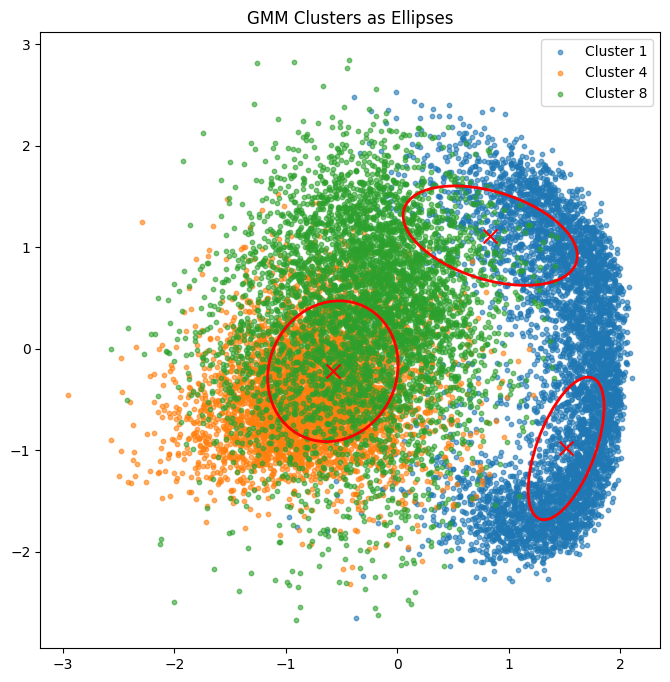

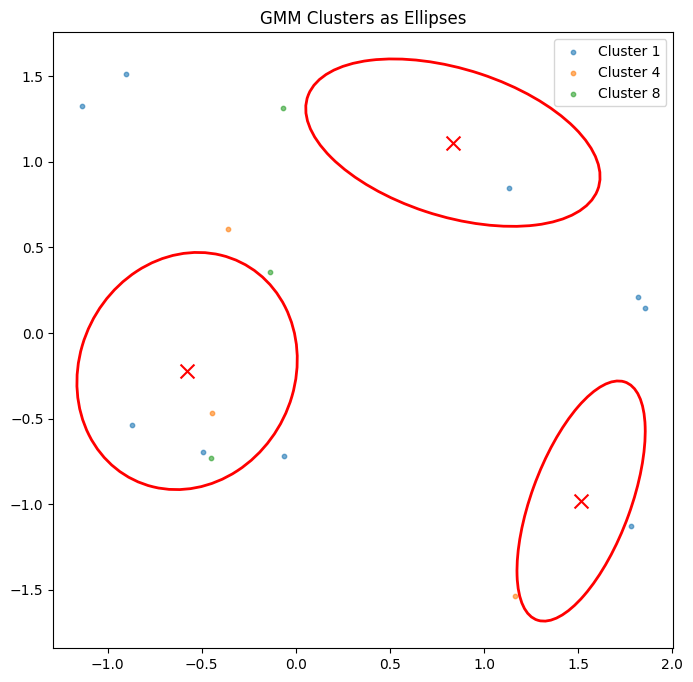

In [107]:
train_latent, train_labels = get_latent_space(train_loader, vae)
test_latent, test_labels = get_latent_space(test_loader, vae)

# Step 2: Fit the GMM model on the latent space data
gmm = GMM(n_components=3)  # Number of clusters (e.g., 3 for digits 1, 4, and 8)
gmm.fit(train_latent)

# Step 3: Plot the GMM clusters for the training data
plot_gmm_ellipses(gmm, train_latent, labels=train_labels)

# Optionally, you can also visualize test data
plot_gmm_ellipses(gmm, test_latent, labels=test_labels)

## Evaluating GMM

The following 4 criteria will be used to evaluate the GMM model after the predictions using latent space vectors from the previously trained Varitational-Autoencoder

In [120]:
def evaluate_gmm_performance(labels_true, labels_pred):
    """
    Evaluate the performance of a GMM using common classification metrics.
    
    :param labels_true: The true labels (ground truth) for the data.
    :param labels_pred: The predicted labels from the GMM.

    :return: A dictionary with accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(labels_true, labels_pred)
    precision_macro = precision_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro precision
    recall_macro = recall_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro recall
    f1_macro = f1_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro F1

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }


In [121]:
labels_val = []
gmm_pred_val = []
for images, labels in test_loader:
    labels_val.append(labels)
    images = images.view(-1, 28*28)
    images = images.to(device)

    encoding = vae.encoder(images)
    means = vae.z_mean(encoding)
    labels_hat = gmm.predict(means.cpu().detach().numpy())
    gmm_pred_val.append(labels_hat)

In [125]:
# Example usage:
metrics = evaluate_gmm_performance(labels_val, gmm_pred_val)
metrics

{'accuracy': 0.13333333333333333,
 'precision_macro': 0.13333333333333333,
 'recall_macro': 0.04444444444444444,
 'f1_macro': 0.06666666666666667}